In [2]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [3]:
!pip install opencv-python numpy matplotlib scikit-image pyheif pillow
!apt-get install libheif-dev

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 104.4 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libheif-dev is already the newest version (1.12.0-2build1).
libheif-dev set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [4]:
# Cell 2: Import All Required Libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import blob_log
from scipy.spatial import KDTree
import math
from PIL import Image
import pyheif
import ipywidgets as widgets
from IPython.display import display
from matplotlib.patches import ConnectionPatch

In [5]:
# Set Image Folder Path and List Available Images
# CHANGE THIS PATH TO YOUR IMAGE FOLDER
image_folder = '/content/drive/MyDrive/star_images'

def get_image_files(folder_path):
    """Get all image files from a folder"""
    supported_formats = ['.jpg', '.jpeg', '.png', '.heic', '.tif']
    files = []
    for f in os.listdir(folder_path):
        if os.path.splitext(f.lower())[1] in supported_formats:
            files.append(os.path.join(folder_path, f))
    return sorted(files)

image_files = get_image_files(image_folder)

print(f"Found {len(image_files)} images:")
for i, f in enumerate(image_files):
    print(f"{i}: {os.path.basename(f)}")

Found 31 images:
0: 3046.jpg
1: @3046.jpg
2: IMG_3046.HEIC
3: IMG_3047.HEIC
4: IMG_3048.HEIC
5: IMG_3049.HEIC
6: IMG_3050.JPG
7: IMG_3051.HEIC
8: IMG_3053.HEIC
9: IMG_3054(1).HEIC
10: IMG_3054.HEIC
11: IMG_3055(1).HEIC
12: IMG_3055.HEIC
13: IMG_3056.HEIC
14: IMG_3057.HEIC
15: IMG_3058.JPG
16: IMG_3059.HEIC
17: IMG_3060.HEIC
18: IMG_3061.HEIC
19: IMG_3062.HEIC
20: IMG_3063.HEIC
21: IMG_3066.JPG
22: IMG_3067.JPG
23: ST_db1.png
24: ST_db2.png
25: Screenshot 2025-04-22 124540.png
26: fr1.jpg
27: fr2.jpg
28: myimage1.jpg
29: myimage2.jpg
30: myimage3.jpg


**Detects stars using Laplacian of Gaussian (blob_log) with preprocessing (blurring, brightness check). Optionally saves results to a log file.**

In [ ]:
# === Part 2: Star Detection and CSV Export ===
#
# In this part, we process a selected astronomical image to detect stars and save their properties to a CSV file.
#
# 1. The image is loaded in grayscale using a custom loader that supports common formats including HEIC, JPG, and PNG.
# 2. We apply preprocessing: normalization and Gaussian blur to reduce noise and enhance blob detection.
# 3. Using the Laplacian of Gaussian (LoG) method (`blob_log`), we detect circular bright regions representing stars.
# 4. For each detected star, we calculate:
#    - (x, y): the center position
#    - radius: the size of the blob
#    - brightness: the average intensity in a small neighborhood around the center
# 5. We filter out faint or small detections based on brightness and radius thresholds.
# 6. The results are saved to a CSV file, and optionally displayed using `matplotlib` with circles and annotations.
#
# This stage provides a reliable detection of stars from a single image, preparing data for analysis or cross-image matching.
# The CSV file becomes a standardized format that is reused in the next part for triangle-based matching.


In [6]:
def load_image(image_path):
    """Load image in grayscale, supports HEIC, PNG, JPG with improved processing"""
    if image_path.lower().endswith('.heic'):
        heif_file = pyheif.read(image_path)
        img = Image.frombytes(
            heif_file.mode,
            heif_file.size,
            heif_file.data,
            "raw",
            heif_file.mode,
            heif_file.stride,
        )
        img = np.array(img)
        if len(img.shape) == 3:  # Convert to grayscale if needed
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    if img is None:
        raise ValueError(f"Image not found or cannot be read: {image_path}")

    return img

def detect_stars(image_path, index=None):
    """Detect stars using Laplacian of Gaussian with improved filtering"""
    img = load_image(image_path)
    img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)

    # Apply Gaussian blur for noise reduction
    blurred = cv2.GaussianBlur(img, (5, 5), 1)

    blobs = blob_log(
        blurred,
        min_sigma=3,
        max_sigma=6,
        num_sigma=10,
        threshold=0.05
    )

    stars = []
    for blob in blobs:
        y, x, r = blob
        r = r * np.sqrt(2)
        x_int, y_int = int(round(x)), int(round(y))

        # Extract a small region around the blob
        patch = img[max(0, y_int-2):y_int+2, max(0, x_int-2):x_int+2]
        brightness = np.mean(patch) / 255 if patch.size > 0 else 0

        # Filter based on brightness and size
        if brightness > 0.2 and r > 1.5:
            stars.append([x, y, r, brightness])

    # Optional logging if index is provided
    if index is not None:
        log_filename = f"stars_output_image_{index}.txt"
        with open(log_filename, "w") as log_file:
            log_file.write(f"Processing: {image_path}\n")
            log_file.write(f"Number of stars in picture {index}: {len(stars)}\n")
            for i, (x, y, r, brightness) in enumerate(stars, start=1):
                output = f"Star {i}: x={x:.1f}, y={y:.1f}, r={r:.1f}, brightness={brightness:.3f}"
                log_file.write(output + "\n")
            print(f"Log saved to: {log_filename}")

    return img, stars

def plot_stars(image, stars, title="Detected Stars", index=None):
    """Show stars with circles and optional index for title"""
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(image, cmap='gray')

    for i, star in enumerate(stars, start=1):
        x, y, r, brightness = star
        circle = plt.Circle((x, y), r * 1.5, color='red', linewidth=1.5, fill=False)
        ax.add_patch(circle)
        ax.plot(x, y, 'r+')

        # Optional annotation
        if len(stars) < 50:  # Don't overcrowd the image
            ax.annotate(f"{i}", (x, y), color='cyan', fontsize=8)

    plt.title(f"{title} {f'({index})' if index else ''}")
    plt.axis('off')
    plt.show()


 Processing: IMG_3047.HEIC


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 Detected 46 stars. CSV exported as: stars_IMG_3047.HEIC.csv


,x,y,radius,brightness
0,2708.0,3922.0,5.185450,0.985539
1,577.0,3384.0,5.656854,0.982108
2,1683.0,3696.0,4.242641,0.984559
3,296.0,896.0,4.242641,0.973529
4,1874.0,2483.0,4.242641,0.973039
5,1630.0,2503.0,4.714045,0.963480
6,2953.0,3142.0,4.242641,0.964951
7,2003.0,3239.0,4.242641,0.764461
8,2191.0,3691.0,4.242641,0.852941
9,35.0,2371.0,4.242641,0.807108


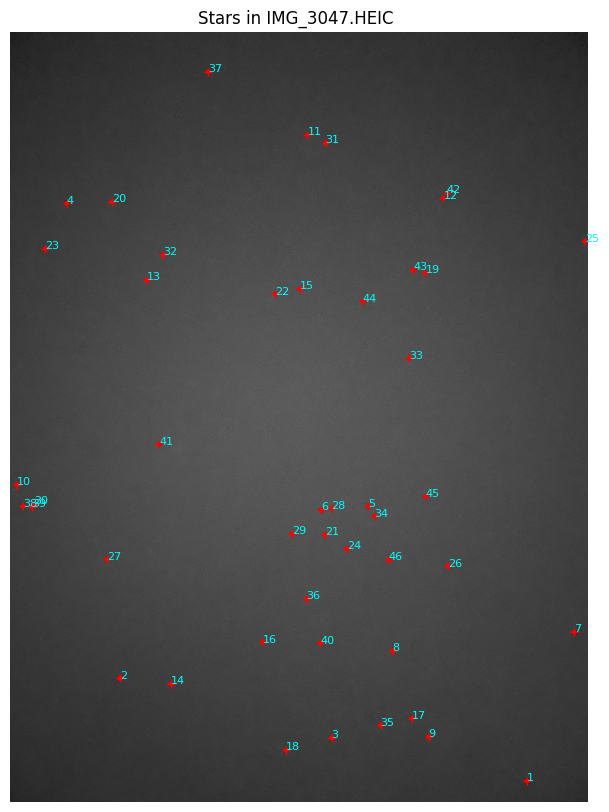

In [10]:
import pandas as pd
from google.colab import files

# === SET IMAGE INDEX TO PROCESS ===
selected_index = 3  # 🔁 Change this index manually

# === VALIDATE AND PROCESS ===
if selected_index < 0 or selected_index >= len(image_files):
    print(f" Invalid index: {selected_index}. Choose 0–{len(image_files) - 1}")
else:
    image_path = image_files[selected_index]
    print(f"\n Processing: {os.path.basename(image_path)}")

    img, stars = detect_stars(image_path)

    if not stars:
        print(" No stars detected.")
    else:
        df = pd.DataFrame(stars, columns=['x', 'y', 'radius', 'brightness'])
        csv_name = f"stars_{os.path.basename(image_path)}.csv"
        df.to_csv(csv_name, index=False, float_format='%.4f')
        files.download(csv_name)

        print(f" Detected {len(stars)} stars. CSV exported as: {csv_name}")
        display(df)
        plot_stars(img, stars, f"Stars in {os.path.basename(image_path)}")


**PART3**

In [ ]:
# === Part 3: Triangle-Based Star Matching Between Two Images ===
#
# In this part, we implement a geometric approach to match stars between two astronomical images.
# Instead of relying solely on (x, y) positions, we use triangle descriptors to capture the spatial
# relationships among triplets of stars. This makes the algorithm robust to scale, rotation, and noise.
#
# 1. We begin by loading the top-N brightest stars from each image’s CSV to focus on the most reliable detections.
# 2. For every combination of 3 stars, we compute a triangle descriptor using their full 4D features: x, y, radius, brightness.
# 3. We compare triangles from both images. If the difference in descriptors is below a threshold, we mark them as matching.
# 4. Each triangle match votes for its corresponding star pairs. The final matches are determined by majority votes.
# 5. Matched stars are visualized by stitching both images side-by-side and drawing lines between the matched points.
#
# This technique improves upon basic coordinate matching by incorporating local geometry,
# allowing for accurate alignment of star patterns even when the views are slightly transformed.


In [50]:
index1 = 3
index2 = 3
image1_path = image_files[index1]
image2_path = image_files[index2]

csv1 = f"stars_{os.path.basename(image1_path)}.csv"
csv2 = f"stars_{os.path.basename(image2_path)}.csv"

# Load top-N stars with all attributes
def load_top_stars_with_features(csv_path, top_n=30):
    df = pd.read_csv(csv_path)
    df = df.sort_values(by='brightness', ascending=False).head(top_n)
    return df[['x', 'y', 'radius', 'brightness']].values.tolist()

stars1 = load_top_stars_with_features(csv1)
stars2 = load_top_stars_with_features(csv2)

In [51]:
import itertools
import numpy as np
from scipy.spatial.distance import euclidean

def triangle_descriptor(p1, p2, p3):
    # Use full 4D vectors for each point: x, y, r, b
    pts = sorted([tuple(p1), tuple(p2), tuple(p3)])  # sort for consistency
    v1 = np.array(pts[0])
    v2 = np.array(pts[1])
    v3 = np.array(pts[2])
    d1 = np.linalg.norm(v1 - v2)
    d2 = np.linalg.norm(v2 - v3)
    d3 = np.linalg.norm(v3 - v1)
    sides = sorted([d1, d2, d3])
    return [sides[0] / sides[2], sides[1] / sides[2]]

def build_triangle_index(stars):
    triangle_data = []
    for tri in itertools.combinations(range(len(stars)), 3):
        i, j, k = tri
        desc = triangle_descriptor(stars[i], stars[j], stars[k])
        triangle_data.append((desc, tri))
    return triangle_data

def match_triangles(index1, index2, threshold=0.05):
    matches = []
    for desc1, tri1 in index1:
        for desc2, tri2 in index2:
            if np.linalg.norm(np.array(desc1) - np.array(desc2)) < threshold:
                matches.append((tri1, tri2))
    return matches

def vote_star_matches(triangle_matches):
    votes = {}
    for t1, t2 in triangle_matches:
        for i, j in zip(t1, t2):
            votes[(i, j)] = votes.get((i, j), 0) + 1

    final_matches = []
    used1, used2 = set(), set()
    for (i, j), count in sorted(votes.items(), key=lambda x: -x[1]):
        if i not in used1 and j not in used2:
            final_matches.append((i, j))
            used1.add(i)
            used2.add(j)
    return final_matches


In [52]:
from PIL import Image
import pyheif
import cv2
import matplotlib.pyplot as plt

def load_image_gray(image_path):
    if image_path.lower().endswith('.heic'):
        heif_file = pyheif.read(image_path)
        img = Image.frombytes(
            heif_file.mode,
            heif_file.size,
            heif_file.data,
            "raw",
            heif_file.mode,
            heif_file.stride,
        )
        img = np.array(img)
        if len(img.shape) == 3:
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    return cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

def visualize_matches(img1_path, stars1, img2_path, stars2, matches):
    img1 = load_image_gray(img1_path)
    img2 = load_image_gray(img2_path)

    h = max(img1.shape[0], img2.shape[0])
    combined = np.zeros((h, img1.shape[1] + img2.shape[1], 3), dtype=np.uint8)
    combined[:img1.shape[0], :img1.shape[1]] = img1
    combined[:img2.shape[0], img1.shape[1]:] = img2

    for i, (idx1, idx2) in enumerate(matches):
        pt1 = tuple(map(int, stars1[idx1][:2]))
        pt2 = (int(stars2[idx2][0] + img1.shape[1]), int(stars2[idx2][1]))
        cv2.line(combined, pt1, pt2, (0, 255, 255), 1)
        cv2.putText(combined, str(i), pt1, cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 255, 0), 1)
        cv2.putText(combined, str(i), pt2, cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 255, 0), 1)

    plt.figure(figsize=(16, 8))
    plt.imshow(combined)
    plt.axis('off')
    plt.title("🔗 Matched Stars with Full Descriptors (x, y, r, b)")
    plt.show()


✅ Matched 30 stars:
  - Image1: [2708.0, 3922.0, 5.1854, 0.9855]  ↔  Image2: [2708.0, 3922.0, 5.1854, 0.9855]
  - Image1: [802.0, 1168.0, 4.2426, 0.4998]  ↔  Image2: [802.0, 1168.0, 4.2426, 0.4998]
  - Image1: [1446.0, 3760.0, 4.2426, 0.5015]  ↔  Image2: [1446.0, 3760.0, 4.2426, 0.5015]
  - Image1: [1683.0, 3696.0, 4.2426, 0.9846]  ↔  Image2: [1683.0, 3696.0, 4.2426, 0.9846]
  - Image1: [1477.0, 2627.0, 4.2426, 0.5176]  ↔  Image2: [1477.0, 2627.0, 4.2426, 0.5176]
  - Image1: [296.0, 896.0, 4.2426, 0.9735]  ↔  Image2: [296.0, 896.0, 4.2426, 0.9735]
  - Image1: [1874.0, 2483.0, 4.2426, 0.973]  ↔  Image2: [1874.0, 2483.0, 4.2426, 0.973]
  - Image1: [577.0, 3384.0, 5.6569, 0.9821]  ↔  Image2: [577.0, 3384.0, 5.6569, 0.9821]
  - Image1: [2091.0, 1709.0, 4.2426, 0.5316]  ↔  Image2: [2091.0, 1709.0, 4.2426, 0.5316]
  - Image1: [1683.0, 2494.0, 4.2426, 0.589]  ↔  Image2: [1683.0, 2494.0, 4.2426, 0.589]
  - Image1: [184.0, 1135.0, 4.2426, 0.5439]  ↔  Image2: [184.0, 1135.0, 4.2426, 0.5439]
  - 

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


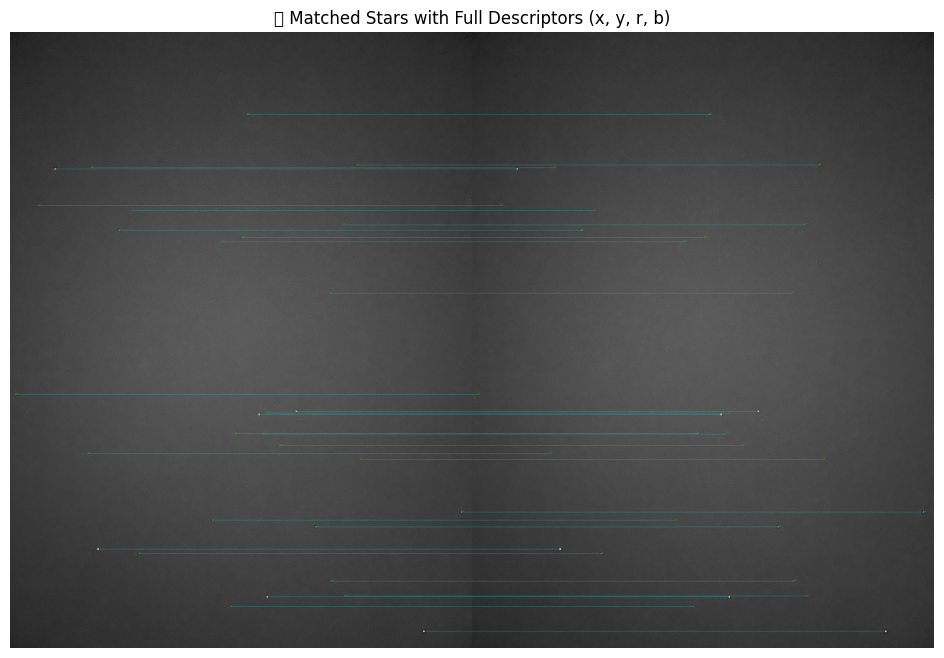

In [53]:
tri_index1 = build_triangle_index(stars1)
tri_index2 = build_triangle_index(stars2)
tri_matches = match_triangles(tri_index1, tri_index2)
matches = vote_star_matches(tri_matches)

print(f" Matched {len(matches)} stars:")
for i1, i2 in matches:
    print(f"  - Image1: {stars1[i1]}  ↔  Image2: {stars2[i2]}")

visualize_matches(image1_path, stars1, image2_path, stars2, matches)
